In [1]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

from helper_functions import plot_compare_history, plot_confusion_matrix, plot_history_curves, plot_random_image
from helper_functions import create_checkpoint_callback, create_early_stopping_callback, create_reduce_lr_callback, create_tensorboard_callback

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [3]:
train_101_100_dir = './Food-Vision-REDO/datasets/food_101/train/'
train_101_50_dir = './Food-Vision-REDO/datasets/food_101/train_50/'
train_101_20_dir = './Food-Vision-REDO/datasets/food_101/train_20/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'

In [4]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'
tensorboard_path = './Food-Vision-REDO/transfer_learning/'

earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True
)

lr_callback = create_reduce_lr_callback(
    metric="val_loss",
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7
)


In [5]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_10_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_20_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_50_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_50_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_100_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

Found 7575 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 37875 files belonging to 101 classes.
Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
class_list_all = glob(os.path.join(test_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;
len(class_list_all)

101

### Building Different Models and Trying to Improve them

#### Building Model 0 

**Experiment** - Model 0  
**Data** - 20% of the data set  
**Preprocessing** - None  
**Model** - Feature Extraction of a Transfer Learning Model  

In [21]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
#x = data_augmentation()
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])



In [22]:
model_0_history = model_0.fit(
    train_data_100_percent,
    epochs=5,
    steps_per_epoch=len(train_data_100_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback, create_tensorboard_callback(
        dir_name=tensorboard_path,
        experiment_name='efficientnetb4_101_data_extraction')]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-154405
Epoch 1/5
2368/2368 [==============================] - 123s 48ms/step - loss: 1.7594 - accuracy: 0.5696 - val_loss: 1.6306 - val_accuracy: 0.5784
Epoch 2/5
2368/2368 [==============================] - 112s 47ms/step - loss: 1.2338 - accuracy: 0.6788 - val_loss: 1.4972 - val_accuracy: 0.6128
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0854 - accuracy: 0.7158INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 173s 73ms/step - loss: 1.0853 - accuracy: 0.7158 - val_loss: 1.4757 - val_accuracy: 0.6155
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.7412INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 174s 73ms/step - loss: 0.9886 - accuracy: 0.7411 - val_loss: 1.4656 - val_accuracy: 0.6192
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.7590INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 174s 73ms/step - loss: 0.9168 - accuracy: 0.7590 - val_loss: 1.4233 - val_accuracy: 0.6314


In [23]:
model_0_evaluation = model_0.evaluate(test_data)

790/790 [==============================] - 34s 42ms/step - loss: 1.2910 - accuracy: 0.6682


In [27]:
cloned_model = tf.keras.models.clone_model(model_0)

In [28]:
cloned_model.load_weights(checkpoint_path)

In [29]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

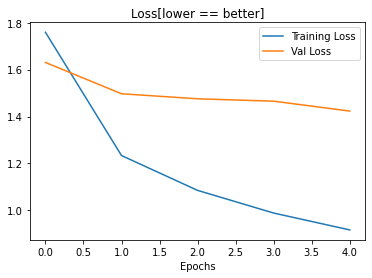

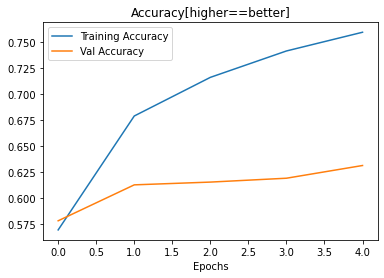

In [24]:
plot_history_curves(model_0_history)

In [31]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model_0.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [43]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [44]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 44s 54ms/step - loss: 1.2910 - accuracy: 0.6682


[1.2909963130950928, 0.6681584119796753]

In [45]:
for layer in loaded_saved_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_avg_pooling True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [46]:
loaded_saved_model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [47]:
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data_100_percent,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data_100_percent),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[
                                                            lr_callback,
                                                            earlystopping_callback,
                                                            checkpoint_callback, 
                                                            create_tensorboard_callback(
                                                                dir_name=tensorboard_path,
                                                                experiment_name='efficientnetb4_101_data_extraction')])

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-163313
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.7804INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 459s 188ms/step - loss: 0.8020 - accuracy: 0.7804 - val_loss: 1.0789 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 374s 158ms/step - loss: 0.4653 - accuracy: 0.8710 - val_loss: 1.2001 - val_accuracy: 0.7161 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9322
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 374s 158ms/step - loss: 0.2405 - accuracy: 0.9322 - val_loss: 1.4030 - val_accuracy: 0.7121 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 372s 157ms/step - loss: 0.0707 - accuracy: 0.9816 - val_loss: 1.5966 - val_accuracy: 0.7251 - lr: 2.0000e-05


In [48]:
loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 36s 46ms/step - loss: 1.4027 - accuracy: 0.7485


[1.4026633501052856, 0.7485148310661316]

In [49]:
loaded_saved_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


> Our model is learning.

now let's check if our model will improve with data augmentation or will stay the same on 10% data.

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [33]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'

In [34]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [35]:
checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True
)

In [36]:
model_0_history = model_0.fit(
    train_data_100_percent,
    epochs=5,
    steps_per_epoch=len(train_data_100_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback, 
               create_tensorboard_callback(
                   dir_name=tensorboard_path,
                   experiment_name='efficientnetb4_101_data_extraction_augmented')]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction_augmented/20211117-191837


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
2368/2368 [==============================] - 143s 57ms/step - loss: 2.1850 - accuracy: 0.4750 - val_loss: 1.7288 - val_accuracy: 0.5691
Epoch 2/5
2368/2368 [==============================] - 132s 56ms/step - loss: 1.6958 - accuracy: 0.5688 - val_loss: 1.5499 - val_accuracy: 0.5985
Epoch 3/5
2368/2368 [==============================] - 135s 57ms/step - loss: 1.5768 - accuracy: 0.5955 - val_loss: 1.5248 - val_accuracy: 0.6073
Epoch 4/5
2368/2368 [==============================] - 134s 56ms/step - loss: 1.5072 - accuracy: 0.6102 - val_loss: 1.4777 - val_accuracy: 0.6194
Epoch 5/5
2368/2368 [==============================] - 137s 58ms/step - loss: 1.4534 - accuracy: 0.6222 - val_loss: 1.4812 - val_accuracy: 0.6197


In [37]:
model_0.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.4443 - accuracy: 0.6251


[1.4443165063858032, 0.6250693202018738]

In [38]:
cloned_model = tf.keras.models.clone_model(model_0)

C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [43]:
cloned_model.load_weights(checkpoint_path)

In [42]:
cloned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [44]:
cloned_model.evaluate(test_data)

790/790 [==============================] - 39s 47ms/step - loss: 1.9802 - accuracy: 0.4982


[1.9802073240280151, 0.4982178211212158]

In [45]:
for layer in cloned_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
  
cloned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"])

input_layer True float32 <Policy "float32">
sequential True float32 <Policy "mixed_float16">
efficientnetb0 True float32 <Policy "mixed_float16">
global_avg_pooling True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [46]:
checkpoint_path = checkpoint_path + 'fine_tune_checkpoints/'
checkpoint_callback = create_checkpoint_callback(checkpoint_path=checkpoint_path,metric='val_loss',save_best=True)

In [ ]:
history_101_food_classes_all_data_fine_tune = cloned_model.fit(train_data_100_percent,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data_100_percent),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[
                                                            lr_callback,
                                                            earlystopping_callback,
                                                            checkpoint_callback, 
                                                            create_tensorboard_callback(
                                                                dir_name=tensorboard_path,
                                                                experiment_name='efficientnetb4_101_data_extraction')])

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-193241
Epoch 1/100
2255/2368 [===========================>..] - ETA: 26s - loss: 1.2589 - accuracy: 0.6696

### Takeaways

Process: 
Generate the Base Model first
If it's overfitting the training set, either add more data or augment the data
in our case we've reached almost perfect training results using the , but our validation data isn't doing very well
so we did augmentation

plot history on every model.

Make a new checkpoint path for every model,
Save our model,
We can clone our model -> load weights from checkpoint -> **compile** -> evaluate

always compile before training



Metrics:

####  Building Model 1

**Experiment** - Model 1  
**Data** - 10%  
**Preprocessing** - Augmentation  
**Model** - Feature Extraction of a Transfer Learning Model 


In [21]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
#x = data_augmentation()
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])



In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [13]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])

model_0_history = model_0.fit(
    train_data_10_percent,
    epochs=5,
    #initial_epoch=model_4_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    #callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/5
237/237 [==============================] - 80s 287ms/step - loss: 3.3673 - accuracy: 0.2665 - val_loss: 2.7040 - val_accuracy: 0.3851
Epoch 2/5
237/237 [==============================] - 43s 183ms/step - loss: 2.3268 - accuracy: 0.4527 - val_loss: 2.2915 - val_accuracy: 0.4632
Epoch 3/5
237/237 [==============================] - 44s 186ms/step - loss: 2.0107 - accuracy: 0.5155 - val_loss: 2.2101 - val_accuracy: 0.4619
Epoch 4/5
237/237 [==============================] - 42s 177ms/step - loss: 1.8057 - accuracy: 0.5552 - val_loss: 2.1362 - val_accuracy: 0.4862
Epoch 5/5
237/237 [==============================] - 42s 175ms/step - loss: 1.6723 - accuracy: 0.5822 - val_loss: 2.0730 - val_accuracy: 0.4950


In [14]:
model_0_evaluation = model_0.evaluate(test_data)

790/790 [==============================] - 77s 98ms/step - loss: 1.9245 - accuracy: 0.5169


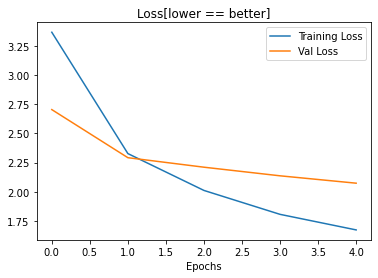

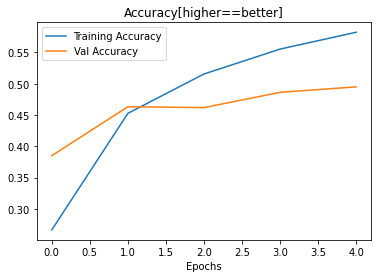

In [15]:
plot_history_curves(model_0_history)

> it seems that our model performed worse on the augmented model, and is already performing bad on the validation set
we'll then stick to the regular dataset

####  Building Model 2

**Experiment** - Model 2  
**Data** - 20%  
**Preprocessing** - n.a.  
**Model** - Feature Extraction and Fine Tuning

In [17]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
#x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])

model_2_history = model_2.fit(
    train_data_20_percent,
    epochs=5,
    #initial_epoch=model_4_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    #callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/5
474/474 [==============================] - 69s 127ms/step - loss: 2.5029 - accuracy: 0.4267 - val_loss: 2.0715 - val_accuracy: 0.4907
Epoch 2/5
474/474 [==============================] - 59s 123ms/step - loss: 1.5833 - accuracy: 0.6007 - val_loss: 1.8573 - val_accuracy: 0.5336
Epoch 3/5
474/474 [==============================] - 59s 124ms/step - loss: 1.3155 - accuracy: 0.6676 - val_loss: 1.7927 - val_accuracy: 0.5405
Epoch 4/5
474/474 [==============================] - 59s 124ms/step - loss: 1.1432 - accuracy: 0.7089 - val_loss: 1.7786 - val_accuracy: 0.5408
Epoch 5/5
474/474 [==============================] - 59s 124ms/step - loss: 1.0078 - accuracy: 0.7479 - val_loss: 1.7201 - val_accuracy: 0.5617


In [18]:
model_2_evaluation = model_2.evaluate(test_data)

790/790 [==============================] - 79s 100ms/step - loss: 1.6292 - accuracy: 0.5845


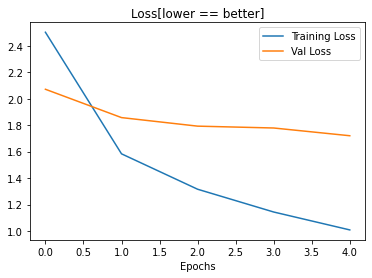

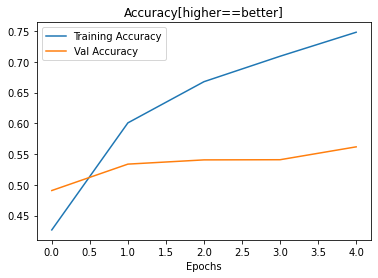

In [19]:
plot_history_curves(model_2_history)

> Yep our model is overfitting on the train data. let's feed it 50% of the data and see how it performs

In [ ]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])

model_2_history = model_2.fit(
    train_data_100_percent,
    epochs=100,
    #initial_epoch=model_4_history.epoch[-1],
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

Epoch 1/100
2368/2368 [==============================] - 258s 105ms/step - loss: 0.9071 - accuracy: 0.7593 - val_loss: 1.5154 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 247s 104ms/step - loss: 0.8594 - accuracy: 0.7732 - val_loss: 1.5006 - val_accuracy: 0.6255 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 248s 105ms/step - loss: 0.8199 - accuracy: 0.7843 - val_loss: 1.5080 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7844 - accuracy: 0.7937
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 248s 105ms/step - loss: 0.7844 - accuracy: 0.7937 - val_loss: 1.5310 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - 248s 105ms/step - loss: 0.6801 - accuracy: 0.8273 - val_loss: 1.4673 - val_accuracy: 0.6351 - lr: 2.0000e-04
Epoch 6/100
2368/2

In [ ]:
model_2.evaluate(test_data)